In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from math import exp, sqrt

In [7]:
def linear(x, y):
    return x @ y


linear = [linear]
polynomial = []
guassian = []

for p in range(2, 5 + 1):
    name = f'polynomial_{p}'
    exec(f'def {name}(x, y): return (1 + x @ y)**{p}')
    exec(f'polynomial.append({name})')

for b in range(1, 5 + 1):
    name = f'guassian_{b}'
    exec(f'def {name}(x, y): return exp({b} * np.linalg.norm(x - y)**2)')
    exec(f'guassian.append({name})')

In [8]:
from subprocess import run, PIPE
from sys import stdout
from io import StringIO
from sklearn.base import BaseEstimator 

class SVM(BaseEstimator):
    def __init__(self, kernel, C):
        super().__init__()
        self.kernel = kernel
        self.C = C
        self.x_train = None
        self.y_train = None
        self.lambdas = None
        self.b = None
        self.distances = None
        self.io = StringIO()


    def calc_matrix(self, x):
        n = x.shape[0]
        self.distances = np.fromfunction(np.vectorize(lambda i, j: self.kernel(x[i], x[j])), (n, n), dtype=int)


    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        self.calc_matrix(x)

        np.savetxt(self.io, np.c_[self.distances, y], fmt='%.8f')
        args = str(self.distances.shape[0]) + '\n' + self.io.getvalue() + str(self.C)
        *self.lambdas, self.b  = map(float, run(['smo.exe'], stdout=PIPE, input=args, encoding='ascii').stdout.split('\n'))
        

    def predict(self, x):
        ans = []
        for obj in x:
            res = self.b
            for l, xi, yi in zip(self.lambdas, self.x_train, self.y_train):
                res += l * yi * self.kernel(obj, xi)
            ans.append(res / abs(res))
        return np.asarray(ans)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt


def show(dataset):
    df = pd.read_csv(dataset + '.csv')
    df['class'].replace({'P': 1, 'N': -1}, inplace=True)
    x_raw = df[['x', 'y']].to_numpy()
    y_raw = df['class'].to_numpy()

    for kernel_type in [linear, polynomial, guassian]:
        param_grid = {'kernel': kernel_type, 'C': [0.05, 0.1]}
        
        clf = GridSearchCV(SVM(None, None), param_grid, cv=5, iid='deprecated', scoring='accuracy')
        clf.fit(x_raw, y_raw)

        x_min = df['x'].min()
        x_max = df['x'].max()
        y_min = df['y'].min()
        y_max = df['y'].max()
        x = xx = np.ogrid[x_min:x_max:100j]
        y = yy = np.ogrid[y_min:y_max:100j]
        space = [(xi, yi) for xi in x for yi in y]

        x, y = zip(*space)
        
        print(clf.best_estimator_)
        background = pd.DataFrame({'x': x, 'y': y, 'class': clf.best_estimator_.predict(space)})
        zz = background['class'].to_numpy().reshape(len(xx), len(yy))
        plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(df['x'], df['y'], c=df['class'], cmap=plt.cm.coolwarm)
        plt.show()

        # sns.jointplot(x='x', y='y', data=background, hue='class')

SVM(C=0.05, kernel=<function linear at 0x000001CBC11ACB88>)


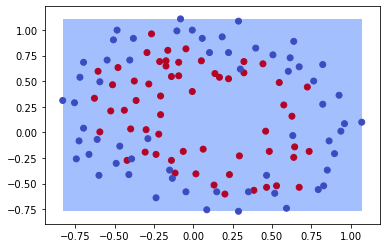

SVM(C=0.1, kernel=<function polynomial_5 at 0x000001CBBF1E8798>)


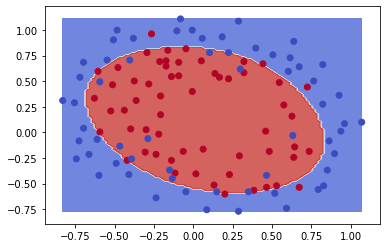

SVM(C=0.05, kernel=<function guassian_1 at 0x000001CBC11ACEE8>)


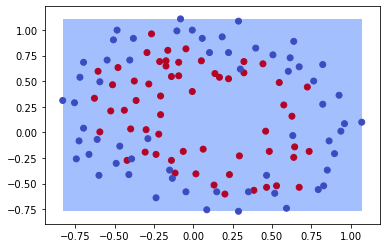

In [10]:
show('chips')

SVM(C=0.05, kernel=<function linear at 0x000001CBC11ACB88>)


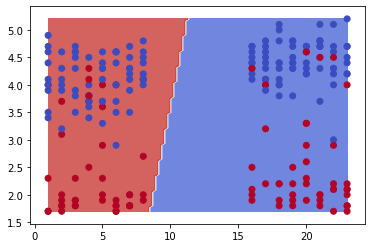

SVM(C=0.05, kernel=<function polynomial_2 at 0x000001CBC11ACDC8>)


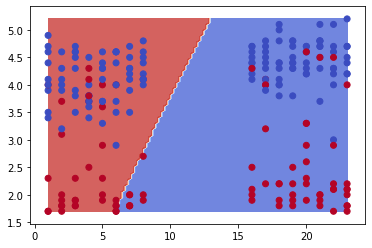

C:\Users\dimna\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [11]:
show('geyser')